In [ ]:
import numpy as np
from glob import glob

import cv2   
import matplotlib.pyplot as plt     

In [5]:
# load dog images
dog_files = np.array(glob("data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 0 total dog images.


In [8]:
import os
import torch
from torchvision import datasets
from torchvision import transforms


## transforms, and batch_sizes
train_transform = transforms.Compose([transforms.RandomResizedCrop(244),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])]) 
test_transform = transforms.Compose([transforms.Resize(225),
                                     transforms.CenterCrop(244),
                                    transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

train_dset = datasets.ImageFolder('/data/dog_images/train/', transform=train_transform)
val_dset = datasets.ImageFolder('/data/dog_images/valid/', transform=test_transform)
test_dset = datasets.ImageFolder('/data/dog_images/test/', transform=test_transform)

loaders_scratch = {
    'train' : torch.utils.data.DataLoader(train_dset, batch_size=32, shuffle=True),
    'test' : torch.utils.data.DataLoader(test_dset, batch_size=32, shuffle=True),
    'valid' : torch.utils.data.DataLoader(val_dset, batch_size=32, shuffle=True)
}


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

The images are resized and cropped in a frame size of 244*244 to compare result to transfer learning models.

For argumentation, we flip random rotate train images for the better fit and generalizations. 

In [39]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN

        self.conv1 = nn.Conv2d(3,16,5,padding=2)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,padding=1)

        self.bc1 = nn.BatchNorm2d(16)
        self.bc2 = nn.BatchNorm2d(32)
        self.bc3 = nn.BatchNorm2d(64)
        self.bc4 = nn.BatchNorm2d(128)   
        
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(15*15*128,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,133)
        
        self.bc_fc1 = nn.BatchNorm1d(1024)
        self.bc_fc2 = nn.BatchNorm1d(512)
    
        self.dropout = nn.Dropout2d(p=.5)
    def forward(self, x):
        ## Define forward behavior
        x = self.bc1(self.pool(F.relu(self.conv1(x))))
        x = self.bc2(self.pool(F.relu(self.conv2(x))))        
        x = self.bc3(self.pool(F.relu(self.conv3(x))))
        x = self.bc4(self.pool(F.relu(self.conv4(x))))

        x = self.dropout(x.view(x.shape[0], -1))
        
        x = self.dropout(self.bc_fc1(F.relu(self.fc1(x))))
        x = self.dropout(self.bc_fc2(F.relu(self.fc2(x))))
        x = F.log_softmax(x, dim = 1)
  
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# # move tensors to GPU if CUDA is available
if True:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bc1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=133, bias=True)
  (bc_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, 

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
We tried different models, and this model best fits. It's derived from `Alexnet` but with Batch Normalization.
Used 4 convolution layers for feature extraction. The kernel size of initial images is bigger because we would like to catch better relative features. Each convolution layer is passed with max pooling layer with kernel size and the stride of 2. After feature extraction we pass the feature vector to the fully connected layer to classify an image.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [22]:
import torch.optim as optim

### TODO: select loss function

criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)



### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

#         train_loss, valid_loss = train_loss/len(loaders['train']), valid_loss/len(loaders['valid'])
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss < valid_loss_min:
            print('Saving Model')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        ## TODO: save the model if validation loss has decreased
            
    # return trained model
    return model


# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, True, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.826334 	Validation Loss: 3.955903
Epoch: 2 	Training Loss: 4.826026 	Validation Loss: 3.860584
Saving Model
Epoch: 3 	Training Loss: 4.833354 	Validation Loss: 3.835989
Saving Model
Epoch: 4 	Training Loss: 4.783208 	Validation Loss: 3.788778
Saving Model
Epoch: 5 	Training Loss: 4.786644 	Validation Loss: 3.750323
Saving Model
Epoch: 6 	Training Loss: 4.827653 	Validation Loss: 3.735185
Saving Model
Epoch: 7 	Training Loss: 4.818615 	Validation Loss: 3.694227
Saving Model
Epoch: 8 	Training Loss: 4.772934 	Validation Loss: 3.711705
Epoch: 9 	Training Loss: 4.801313 	Validation Loss: 3.708015
Epoch: 10 	Training Loss: 4.827687 	Validation Loss: 3.753609
Epoch: 11 	Training Loss: 4.785099 	Validation Loss: 3.699762
Epoch: 12 	Training Loss: 4.777802 	Validation Loss: 3.750700
Epoch: 13 	Training Loss: 4.781232 	Validation Loss: 3.611180
Saving Model
Epoch: 14 	Training Loss: 4.793339 	Validation Loss: 3.635408
Epoch: 15 	Training Loss: 4.785834 	Validation Los

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, True)

Test Loss: 3.208596


Test Accuracy: 30% (257/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [9]:
## TODO: Specify data loaders

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])]) 
test_transform = transforms.Compose([transforms.Resize(225),
                                     transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('/data/dog_images/train/', transform=train_transform)
val_dataset = datasets.ImageFolder('/data/dog_images/valid/', transform=test_transform)
test_dataset = datasets.ImageFolder('/data/dog_images/test/', transform=test_transform)

loaders_transfer = {
    'train' : torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True),
    'test' : torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True),
    'valid' : torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
import torchvision.models as models
import torch.nn as nn

## model architecture 
model_transfer = models.resnet50(pretrained=True)
fc = nn.Linear(2048,133)
model_transfer.fc = fc
print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 69223094.46it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

We choose `ResNet` architecture as it performance is better than compared to other architecture. It's prone to Vanishing gradient problem as the core idea of ResNet is `identity shortcut connection`.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [16]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
n_epochs = 50
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 7.066871 	Validation Loss: 2.903180
Saving Model
Epoch: 2 	Training Loss: 4.597270 	Validation Loss: 3.844484
Epoch: 3 	Training Loss: 4.617620 	Validation Loss: 2.940484
Epoch: 4 	Training Loss: 4.780191 	Validation Loss: 2.882025
Saving Model
Epoch: 5 	Training Loss: 4.589712 	Validation Loss: 2.800382
Saving Model
Epoch: 6 	Training Loss: 4.890459 	Validation Loss: 2.564351
Saving Model
Epoch: 7 	Training Loss: 5.048828 	Validation Loss: 3.615060
Epoch: 9 	Training Loss: 5.101510 	Validation Loss: 3.074827
Epoch: 10 	Training Loss: 5.098487 	Validation Loss: 3.074027
Epoch: 11 	Training Loss: 4.757476 	Validation Loss: 2.427136
Saving Model
Epoch: 12 	Training Loss: 4.931932 	Validation Loss: 2.949529
Epoch: 13 	Training Loss: 5.026719 	Validation Loss: 2.960131
Epoch: 14 	Training Loss: 4.991848 	Validation Loss: 3.194252
Epoch: 15 	Training Loss: 5.181325 	Validation Loss: 3.159330
Epoch: 16 	Training Loss: 5.171299 	Validation Loss: 2.886480
Epoch: 17 	Tr

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.532971


Test Accuracy: 78% (656/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [29]:
from PIL import Image

In [185]:
import torch.nn.functional as F

In [120]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_dataset.classes]


def predict_breed_transfer(img_path):
    k = 3
    img = Image.open(img_path)
    img_trans = test_transform(img)
    img_batch = torch.unsqueeze(img_trans,0)
    if use_cuda:
        img_batch = img_batch.cuda()
    model_transfer.eval()
    output = F.softmax(model_transfer(img_batch), dim=1)
    value,  index = output.topk(k, dim=1)
    # load the image and return the predicted breed
    value,  index = value.cpu().detach().numpy(),  index.cpu().detach().numpy()
    return dict([(class_names[index[0][i]], value[0][i]) for i in range(k)])


In [1]:
def plot(pred):
    figure = plt.figure(figsize=(24,30))
    total = len(pred)
    i=0
    for link, title, pred in pred:
        ax1 = figure.add_subplot(total*2,2,i+1, frameon=False)
        ax1.imshow(plt.imread(link))
        ax1.tick_params(bottom="off",left="off",labelbottom='off', labelleft='off')
        ax2 = figure.add_subplot(total*2,2,i+2,frameon=False)    
        ax2.set_title(title)
        if type(pred) is list:
            ax2.tick_params(bottom="off",labelbottom='off', left="off")
            continue
        pos = range(len(pred),0,-1)
        ax2.barh(pos, list(pred.values()),tick_label=list(pred.keys()))
        ax2.set_xlim([0,1])
        ax2.tick_params(bottom="off",labelbottom='off')
        i+=4
    plt.show()


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [123]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        #dog detected
        breeds_predicts = predict_breed_transfer(img_path)
        return "DOG Detected!! \n You are one of the following Dogs", breeds_predicts
    elif face_detector(img_path):
        #human face detected
        breeds_predicts = predict_breed_transfer(img_path)
        return "Hey Human!! \n You look like one of the following Dogs", breeds_predicts
      
    else:
        return "Hmm, I think you are neither dog nor human", []
        #neither face or dog

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The model performed better than expected it classified batman as human and to its close dog breed. Although it mis-classified few images. We can improve the model in the following ways:
1. Further data argumentation.
2. Inresase in data size.
3. Weight initlization and hyperparameter tuning.

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
predictions = []
for file in np.hstack((human_files[:3], dog_files[:3])):
    text, breed = run_app(file)
    predictions.append((file,text,breed))

plot(predictions)

In [125]:
#test on custom images
human_custom = np.array(glob('custom_images/humans/*'))
dog_custom = np.array(glob('custom_images/dogs/*'))

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


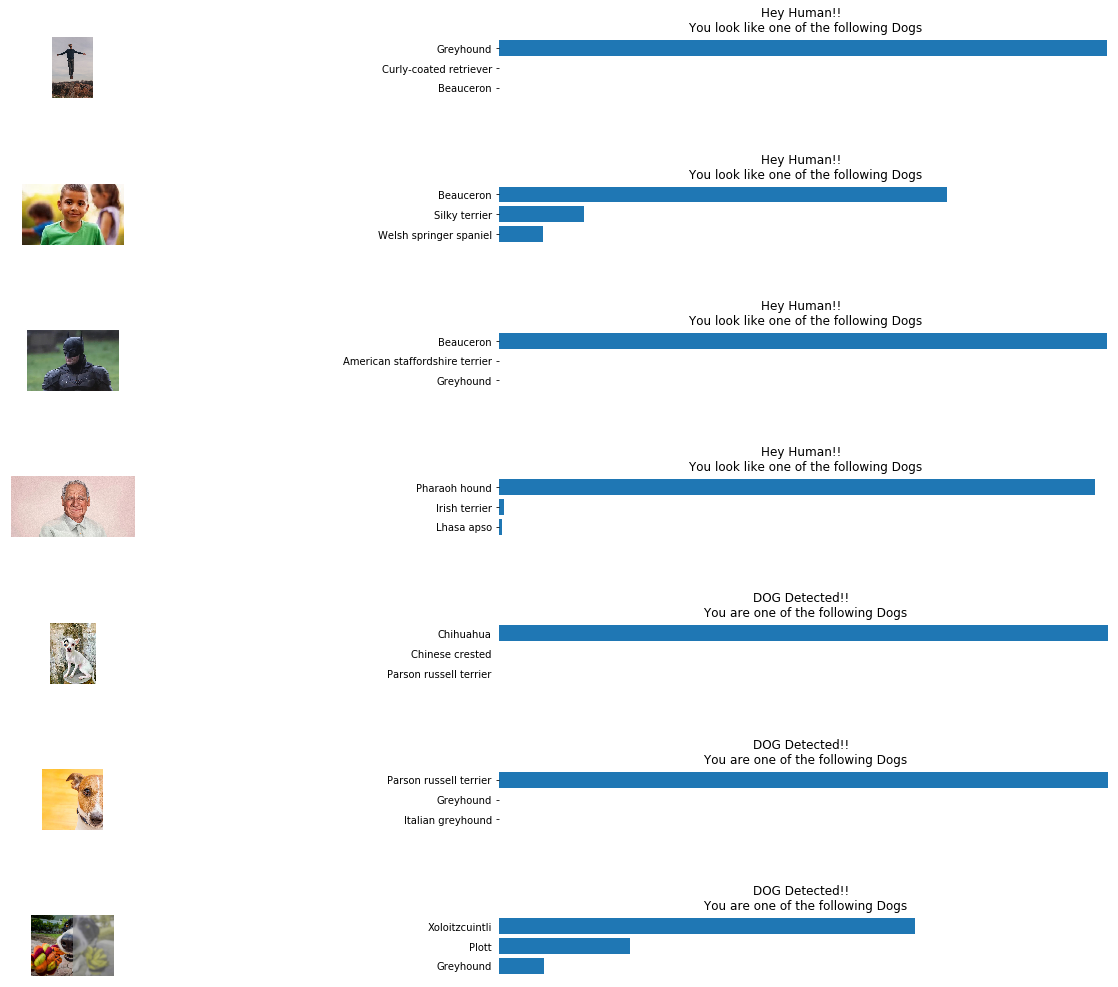

In [131]:
predictions = []
for file in np.hstack((human_custom, dog_custom)):
    text, breed = run_app(file)
    predictions.append((file,text,breed))

plot(predictions)